In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [218]:
driving_data = pd.read_csv(r"C:\Users\zahid\Desktop\FINAL_PROJECT_FILES\work\data cleaning\dedo\cleaned_harsh_data.csv")
#driving_data = pd.read_csv(r"C:\Users\zahid\Desktop\FINAL_PROJECT_FILES\work\data cleaning\dedo\cleaned_1.csv")
#driving_data = pd.read_csv(r"C:\Users\zahid\Desktop\FINAL_PROJECT_FILES\work\data cleaning\dedo\cleaned_2.csv")
#driving_data = pd.read_csv(r"C:\Users\zahid\Desktop\FINAL_PROJECT_FILES\work\data cleaning\dedo\cleaned_3.csv")



In [220]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_chunk(chunk_df):
    chunk_df = chunk_df.copy()
    chunk_df['labels'] = 'Normal'  # Initialize labels column

    results = {
        'start_index': chunk_df.iloc[0]['Counter'],
        'end_index': chunk_df.iloc[-1]['Counter'],
        'distance_km': chunk_df['distance'].sum(),
        'detected_events': 0,
        'harsh_braking_events': 0,
        'harsh_acceleration_events': 0,
        'swerving_events': 0,
        'potential_swerving_events': 0,
        'over_speed_events': 0
    }

    # Compute magnitude variance and its mean
    chunk_df['magnitude_variance'] = chunk_df['acceleration_magnitude'].rolling(window=2, min_periods=1).var()
    mean_variance = chunk_df['acceleration_magnitude'].mean()

    # Count events where variance exceeds mean
    event_mask = chunk_df['magnitude_variance'] > mean_variance
    results['detected_events'] = event_mask.sum()

    # Update labels for events
    chunk_df.loc[event_mask, 'labels'] = 'Event'

    # Apply second filter only if an event is detected from the first filter
    if results['detected_events'] > 0:
        # Harsh Braking: Calculate variance of negative acceleration along X-axis and mean
        chunk_df['negative_ax'] = chunk_df['Ax'].where(chunk_df['Ax'] < 0)
        chunk_df['negative_ax_variance'] = chunk_df['negative_ax'].rolling(window=35, min_periods=1).var()
        mean_negative_ax_variance = chunk_df['negative_ax_variance'].mean()
        std_negative_ax_variance = chunk_df['negative_ax_variance'].std()
        
        threshold = mean_negative_ax_variance + 1.5 * std_negative_ax_variance

        # Add condition to exclude values <= -2000 m/s²
        harsh_braking_mask = (
            (chunk_df['negative_ax_variance'] > threshold) &
            (chunk_df['Ax'] < -2000)  # New exclusion condition
        )
        results['harsh_braking_events'] = harsh_braking_mask.sum()

        # Harsh Acceleration: Calculate variance of positive acceleration along X-axis and mean
        chunk_df['positive_ax'] = chunk_df['Ax'].where(chunk_df['Ax'] > 0)
        chunk_df['positive_ax_variance'] = chunk_df['positive_ax'].rolling(window=35, min_periods=1).var()
        mean_positive_ax_variance = chunk_df['positive_ax_variance'].mean()
        std_positive_ax_variance = chunk_df['positive_ax_variance'].std()
        
        threshold_Acceleration = mean_positive_ax_variance + 1.5 * std_positive_ax_variance
        
        # Add condition to exclude values >= 2000 m/s²
        harsh_acceleration_mask = (
            (chunk_df['positive_ax_variance'] > threshold_Acceleration) &
            (chunk_df['Ax'] > 2000)  # New exclusion condition
        )
        results['harsh_acceleration_events'] = harsh_acceleration_mask.sum()

        # Swerving detection logic
        window_swerve = 12  # Window size for checking angle change
        chunk_df['yaw_change'] = chunk_df['Yaw'].rolling(window=window_swerve, min_periods=1, center=True).apply(lambda x: max(x) - min(x), raw=True).abs()
        swerve_mask = (
            (chunk_df['yaw_change'] >= 4) & (chunk_df['yaw_change'] <= 12) & 
            (chunk_df['Ay'].abs() > 2000)  # Aggressiveness condition based on Az
        )
        results['swerving_events'] = swerve_mask.sum()
        
        # Update labels 
        chunk_df.loc[harsh_acceleration_mask, 'labels'] = 'Harsh Acceleration'
        chunk_df.loc[swerve_mask, 'labels'] = 'Swerving'
        chunk_df.loc[harsh_braking_mask, 'labels'] = 'Harsh Braking'
        
        # Additional logic to reset label to 'Normal' if change in degree > 40 in a window of 50 readings
        window_reset = 90
        chunk_df['large_yaw_change'] = chunk_df['Yaw'].rolling(window=window_reset, min_periods=1, center=True).apply(lambda x: max(x) - min(x), raw=True).abs()
        reset_mask = chunk_df['large_yaw_change'] > 40
        chunk_df.loc[reset_mask, 'labels'] = 'Normal'

    # Check for potential harsh braking in 'Normal' labeled data
    normal_data_mask = ((chunk_df['labels'] == 'Normal') | (chunk_df['labels'] == 'Event')) & (chunk_df['Ax'] < -2000)
    chunk_df.loc[normal_data_mask, 'labels'] = 'Harsh Braking'

    # Potential swerving detection
    potential_swerve_mask = (
        (chunk_df['Ay'].abs() > 2000) &
        (chunk_df['labels'].isin(['Normal', 'Event']))
    )
    results['potential_swerving_events'] = potential_swerve_mask.sum()
    chunk_df.loc[potential_swerve_mask, 'labels'] = 'Swerving'
    
    over_speed_mask = chunk_df['Speed(km/h)'] > 120
    results['over_speed_events'] = over_speed_mask.sum()
    chunk_df.loc[over_speed_mask, 'labels'] = 'Over Speed'

    normal_mask = (chunk_df['labels'] == 'Event')
    chunk_df.loc[normal_mask, 'labels'] = 'Normal'

    speed_mask = ((chunk_df['labels'] == 'Swerving') & (chunk_df['Speed(km/h)'] < 30))
    chunk_df.loc[speed_mask, 'labels'] = 'Normal'

    # Add harsh_braking_event column (NEW LOGIC)
    chunk_df['harsh_braking_event'] = 0
    prev_label = chunk_df['labels'].shift(1).fillna('Normal')
    new_event_mask = (chunk_df['labels'] == 'Harsh Braking') & (prev_label != 'Harsh Braking')
    chunk_df.loc[new_event_mask, 'harsh_braking_event'] = 1
    if not chunk_df.empty and chunk_df.iloc[0]['labels'] == 'Harsh Braking':
        chunk_df.at[chunk_df.index[0], 'harsh_braking_event'] = 1
    results['harsh_braking_events'] = chunk_df['harsh_braking_event'].sum()  # Update count

 
    
    return chunk_df, results


In [222]:
'''
results = {
    'start_index': chunk_df.iloc[0]['Counter'],
    'end_index': chunk_df.iloc[-1]['Counter'],
    'distance_km': chunk_df['distance'].sum(),
    'detected_events': event_mask.sum(),
    'harsh_braking_events': harsh_braking_mask.sum(),
    'harsh_acceleration_events': harsh_acceleration_mask.sum(),
    'swerving_events': swerve_mask.sum(),
    'potential_swerving_events': potential_swerve_mask.sum(),
    'over_speed_events': over_speed_mask.sum()
    '''
def score_chunk(chunk_df, results):
    # Initialize score to 100%
    score = 100

    # Define weights for each type of event
    harsh_braking_weight = 20  
    harsh_acceleration_weight = 10 
    swerving_weight = 30 
    overspeed_weight = 20  

    # Apply scoring deductions based on detected events
    score -= results['harsh_braking_events'] * harsh_braking_weight
    score -= results['harsh_acceleration_events'] * harsh_acceleration_weight
    score -= results['swerving_events'] * swerving_weight
    score -= results['over_speed_events'] * overspeed_weight

    # Ensure the score doesn't go below 0%
    score = max(score, 0)

    return score

In [224]:
accumulated_distance = 0.0
current_chunk = []
segment_data = []
scores = []
for index, row in driving_data.iterrows():
    accumulated_distance += row['distance']
    current_chunk.append(row)
    
    if accumulated_distance >= 0.1:  # 100-meter chunks
        chunk_df = pd.DataFrame(current_chunk)
        labeled_chunk, analysis_results = analyze_chunk(chunk_df)
        score = score_chunk(chunk_df,analysis_results)
        
        # Update labels AND new column in original dataframe
        for idx in labeled_chunk.index:
            driving_data.at[idx, 'labels'] = labeled_chunk.at[idx, 'labels']
            driving_data.at[idx, 'harsh_braking_event'] = labeled_chunk.at[idx, 'harsh_braking_event']
        
        segment_data.append(analysis_results)
        accumulated_distance = 0.0
        scores.append(score)
        current_chunk = []

In [225]:
# Process remaining data
if current_chunk:
    chunk_df = pd.DataFrame(current_chunk)
    if not chunk_df.empty:
        labeled_chunk, analysis_results = analyze_chunk(chunk_df)
        for idx in labeled_chunk.index:
            driving_data.at[idx, 'labels'] = labeled_chunk.at[idx, 'labels']
            driving_data.at[idx, 'harsh_braking_event'] = labeled_chunk.at[idx, 'harsh_braking_event']
        segment_data.append(analysis_results)

In [228]:
# Create final outputs
segments_df = pd.DataFrame(segment_data)

# Calculate totals
total_harsh_braking = segments_df['harsh_braking_events'].sum()

print("Processing complete!")
print(f"Total chunks processed: {len(segment_data)}")
print(f"Total harsh braking events: {total_harsh_braking}")
print("\nFirst 5 labeled rows:")
print(driving_data[['Counter', 'labels', 'harsh_braking_event']].head())

# Save results
driving_data.to_csv('labeled_driving_data.csv', index=False)
segments_df.to_csv('chunk_analysis.csv', index=False)

Processing complete!
Total chunks processed: 30
Total harsh braking events: 25

First 5 labeled rows:
   Counter  labels  harsh_braking_event
0        1  Normal                  0.0
1        2  Normal                  0.0
2        3  Normal                  0.0
3        4  Normal                  0.0
4        5  Normal                  0.0


labels
Normal                992
Harsh Braking         133
Swerving               39
Harsh Acceleration      8
Name: count, dtype: int64


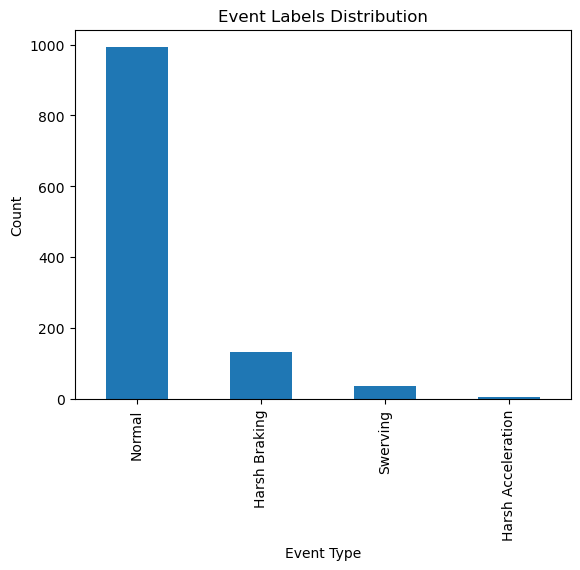

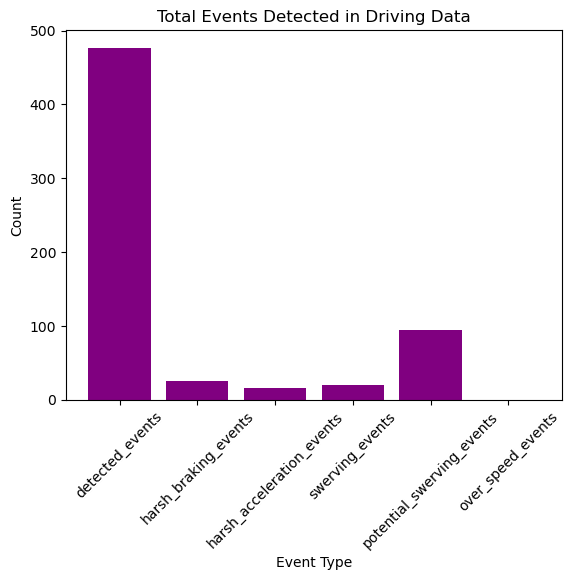

Final Score: 61.0


In [239]:
# Visualization of labels distribution
label_counts = driving_data['labels'].value_counts()
print(label_counts)
driving_data['labels'].value_counts().plot(kind='bar', title='Event Labels Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

# Visualization of results parameters
result_types = ['detected_events', 'harsh_braking_events', 'harsh_acceleration_events', 'swerving_events', 'potential_swerving_events', 'over_speed_events']
result_sums = {result_type: sum([chunk[result_type] for chunk in segment_data]) for result_type in result_types}

plt.bar(result_sums.keys(), result_sums.values(), color='purple')
plt.title('Total Events Detected in Driving Data')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Calculate final score
total_score = sum(scores)
final_score = total_score / len(segment_data)
print(f"Final Score: {final_score}")